In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb 
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
df=pd.read_csv('hotels.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2781 entries, 0 to 2780
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_id          2781 non-null   int64  
 1   city                 2781 non-null   object 
 2   name                 2781 non-null   object 
 3   rooms                2600 non-null   float64
 4   integration_service  1879 non-null   object 
 5   seasonal             2684 non-null   object 
 6   partnership_status   2778 non-null   object 
 7   activated_method     2781 non-null   object 
 8   first_activated_at   2753 non-null   object 
 9   first_year_ends      2753 non-null   object 
 10  trips                2781 non-null   int64  
 11  revenue              2781 non-null   float64
 12  revenue_per_trip     2781 non-null   float64
 13  tc                   2781 non-null   float64
 14  dc                   2781 non-null   float64
 15  trips_first_year     2781 non-null   i

In [4]:
df.isnull().sum()

property_id              0
city                     0
name                     0
rooms                  181
integration_service    902
seasonal                97
partnership_status       3
activated_method         0
first_activated_at      28
first_year_ends         28
trips                    0
revenue                  0
revenue_per_trip         0
tc                       0
dc                       0
trips_first_year         0
revenue_first_year       0
tc_first_year            0
dc_first_year            0
dtype: int64

In [5]:
#feature engineering
df['integration_service'] = df['integration_service'].fillna('light')
df['integration_service'] = df['integration_service'].replace({'BookingCom':'Schedulers'})
df['integration_service'] = df['integration_service'].replace({'Expedia':'Schedulers'})
df['seasonal'] = df['seasonal'].fillna(0)
df['seasonal'] = df['seasonal'].replace({True: "Yes", False: "No"})
df['revenue_per_trip_first_year']=df['revenue_first_year']/df['trips_first_year']

## drop nas
df.dropna(subset=['partnership_status'],inplace=True)
df.dropna(subset=['first_activated_at'],inplace=True)
df.dropna(subset=['rooms'],inplace=True)
df.dropna(subset=['revenue_per_trip_first_year'],inplace=True)

## drop columns
df.drop(columns='property_id',inplace=True)
df.drop(columns='trips',inplace=True)
df.drop(columns='tc',inplace=True)
df.drop(columns='dc',inplace=True)
df.drop(columns='dc_first_year',inplace=True)
df.drop(columns='tc_first_year',inplace=True)
df.drop(columns='revenue_per_trip',inplace=True)
df.drop(columns='revenue',inplace=True)
df.drop(columns='activated_method',inplace=True)

In [6]:
df.isnull().sum()

city                           0
name                           0
rooms                          0
integration_service            0
seasonal                       0
partnership_status             0
first_activated_at             0
first_year_ends                0
trips_first_year               0
revenue_first_year             0
revenue_per_trip_first_year    0
dtype: int64

In [20]:
df.sort_values(by='revenue_first_year',ascending=False)

,city,name,rooms,integration_service,seasonal,partnership_status,first_activated_at,first_year_ends,trips_first_year,revenue_first_year,revenue_per_trip_first_year
4,athens,Electra Metropolis Athens,216.0,light,No,Revisit Lead,2017-01-13,2018-01-13,345,43703.8,126.677681
10,istanbul,Radisson Hotel President Old Town Istanbul,201.0,Schedulers,No,Active Partnership,2023-09-14,2024-09-13,239,24207.6,101.287029
194,paris,Hôtel Brighton Paris,61.0,availpro,No,Active Partnership,2022-11-17,2023-11-17,314,23994.3,76.414968
63,athens,Electra Palace Hotel,155.0,light,No,Stopped Partnership,2016-07-08,2017-07-08,158,19495.7,123.390506
41,athens,The Athens Gate Hotel,99.0,webhotelier,No,Active Partnership,2017-05-18,2018-05-18,338,19220.6,56.865680
...,...,...,...,...,...,...,...,...,...,...,...
1657,malaga,Hotel Monarque Cendrillon,56.0,light,No,Active Partnership,2019-05-08,2020-05-07,1,0.4,0.400000
1827,corfu,Seaside Suites,2.0,Schedulers,Yes,Active Partnership,2022-02-27,2023-02-27,3,-19.6,-6.533333
1674,corfu,Corfu Sun Gate Hotel,50.0,webhotelier,Yes,Active Partnership,2022-05-10,2023-05-10,1,-24.8,-24.800000
1946,munich,Peterhof Freising by Charly,17.0,light,No,Paused Partnership (Hotel closed),2022-08-17,2023-08-17,4,-98.1,-24.525000


C:\Users\marag\AppData\Local\Temp\ipykernel_63056\4019656266.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sb.heatmap(df.corr(), annot = True, cmap='Blues')


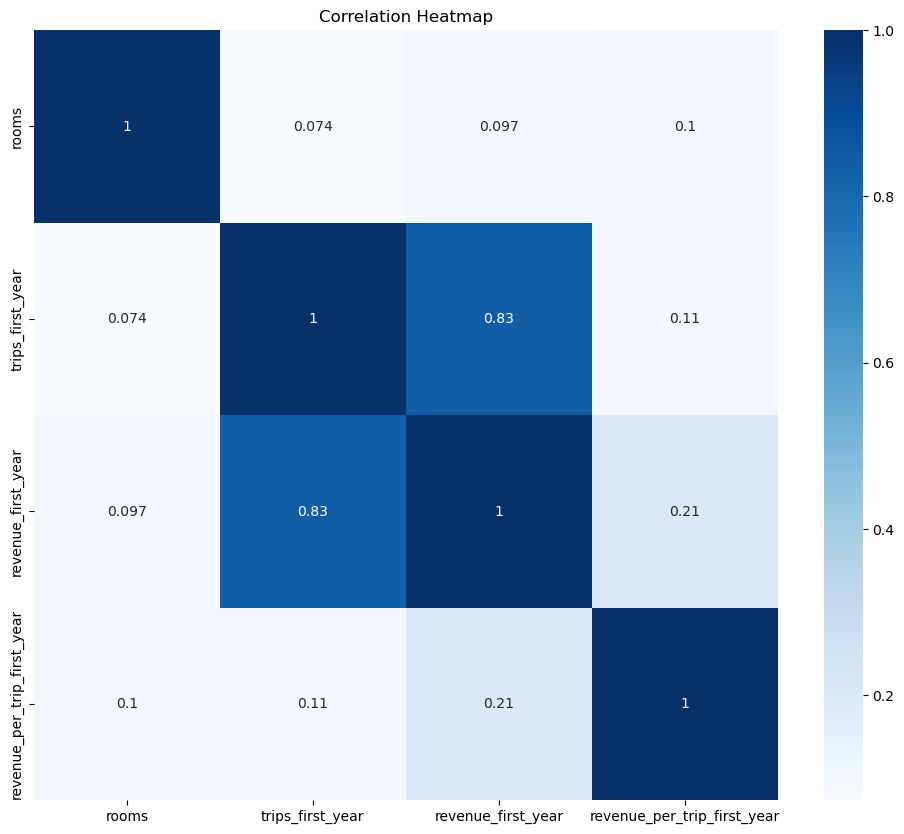

In [8]:
plt.figure(figsize = (12,10))
plt.title('Correlation Heatmap')
heatmap = sb.heatmap(df.corr(), annot = True, cmap='Blues')

In [9]:
df.describe()

,rooms,trips_first_year,revenue_first_year,revenue_per_trip_first_year
count,1879.000000,1879.000000,1879.000000,1879.000000
mean,73.979776,41.067057,1060.830208,21.911509
std,82.510545,53.711877,2174.666574,28.546321
min,0.000000,1.000000,-157.800000,-52.600000
25%,22.000000,5.000000,82.200000,15.003728
50%,46.000000,19.000000,341.100000,18.833333
75%,94.000000,56.000000,1149.700000,24.687103
max,709.000000,345.000000,43703.800000,1127.900000


In [10]:
X_revenue = df[['city', 'integration_service', 'seasonal', 'rooms']]
y_revenue = df['revenue_per_trip_first_year']

categorical_features = ['city', 'integration_service','seasonal']
one_hot = OneHotEncoder(handle_unknown='ignore')

preprocessor_revenue = ColumnTransformer(
    transformers=[('cat', one_hot, categorical_features)],
    remainder='passthrough'
)

models_revenue = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'ElasticNet': ElasticNet(random_state=42),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42),
    'SVR': SVR()
}

def evaluate_models_revenue(models_revenue, X_revenue, y_revenue):
    results_revenue = {}
    for name, model in models_revenue.items():
        pipeline_revenue = Pipeline(steps=[('preprocessor', preprocessor_revenue),
                                   ('model', model)])
        
        X_train_revenue, X_test_revenue, y_train_revenue, y_test_revenue = train_test_split(X_revenue, y_revenue, test_size=0.2, random_state=42)
        
        pipeline_revenue.fit(X_train_revenue, y_train_revenue)
        
        y_pred_revenue = pipeline_revenue.predict(X_test_revenue)
        
        mse = mean_squared_error(y_test_revenue, y_pred_revenue)
        rmse = np.sqrt(mse)
        
        cv_scores = cross_val_score(pipeline_revenue, X_revenue, y_revenue, cv=5, scoring='neg_mean_squared_error')
        cv_rmse = np.sqrt(-cv_scores.mean())
        
        results_revenue[name] = {
            'MSE': mse,
            'RMSE': rmse,
            'CV_RMSE': cv_rmse
        }
        
        print(f"{name} - MSE: {mse}, RMSE: {rmse}, CV_RMSE: {cv_rmse}")
    
    return results_revenue

model_results_revenue = evaluate_models_revenue(models_revenue, X_revenue, y_revenue)

LinearRegression - MSE: 135.23863977243184, RMSE: 11.629214925025328, CV_RMSE: 28.5542252857843
Ridge - MSE: 133.01191224934027, RMSE: 11.533079044615114, CV_RMSE: 28.48938332523511
Lasso - MSE: 127.09980060037019, RMSE: 11.27385473564256, CV_RMSE: 28.466190176173626
ElasticNet - MSE: 126.45922574811084, RMSE: 11.245409096520715, CV_RMSE: 28.457244958819413
RandomForestRegressor - MSE: 123.16502277875999, RMSE: 11.097973814113997, CV_RMSE: 29.29610127940431
GradientBoostingRegressor - MSE: 131.7533794694904, RMSE: 11.47838749430818, CV_RMSE: 28.67162885058359
XGBRegressor - MSE: 115.57572563673634, RMSE: 10.750615128295513, CV_RMSE: 28.83397511789816
SVR - MSE: 134.16543694168894, RMSE: 11.582980486113621, CV_RMSE: 28.577763280852682


In [11]:
X_trips = df[['city', 'integration_service', 'seasonal', 'rooms']]
y_trips = df['trips_first_year']

categorical_features = ['city', 'integration_service','seasonal']
one_hot = OneHotEncoder(handle_unknown='ignore')

preprocessor_trips = ColumnTransformer(
    transformers=[('cat', one_hot, categorical_features)],
    remainder='passthrough'
)

models_trips = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'ElasticNet': ElasticNet(random_state=42),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42),
    'SVR': SVR()
}

# Function to perform training and cross-validation
def evaluate_models_trips(models_trips, X_trips, y_trips):
    results_trips = {}
    for name, model in models_trips.items():
        pipeline_trips = Pipeline(steps=[('preprocessor', preprocessor_trips),
                                   ('model', model)])
        
        X_train_trips, X_test_trips, y_train_trips, y_test_trips = train_test_split(X_trips, y_trips, test_size=0.2, random_state=42)
        
        pipeline_trips.fit(X_train_trips, y_train_trips)
        
        y_pred_trips = pipeline_trips.predict(X_test_trips)
        
        mse = mean_squared_error(y_test_trips, y_pred_trips)
        rmse = np.sqrt(mse)
        
        cv_scores = cross_val_score(pipeline_trips, X_trips, y_trips, cv=5, scoring='neg_mean_squared_error')
        cv_rmse = np.sqrt(-cv_scores.mean())
        
        results_trips[name] = {
            'MSE': mse,
            'RMSE': rmse,
            'CV_RMSE': cv_rmse
        }
        
        print(f"{name} - MSE: {mse}, RMSE: {rmse}, CV_RMSE: {cv_rmse}")
    
    return results_trips

model_results_trips = evaluate_models_trips(models_trips, X_trips, y_trips)


LinearRegression - MSE: 2394.378122783931, RMSE: 48.932383170901566, CV_RMSE: 59.30313317581172
Ridge - MSE: 2326.2409159184235, RMSE: 48.231119787108646, CV_RMSE: 58.8786402394994
Lasso - MSE: 2350.038853128179, RMSE: 48.4771993119258, CV_RMSE: 60.37721269175014
ElasticNet - MSE: 2562.841025571476, RMSE: 50.62451012673087, CV_RMSE: 60.90005717986587
RandomForestRegressor - MSE: 2983.413855430402, RMSE: 54.62063580214351, CV_RMSE: 62.856361961121024
GradientBoostingRegressor - MSE: 2241.328786253462, RMSE: 47.34267405051664, CV_RMSE: 59.15686088135469
XGBRegressor - MSE: 2623.7656217800904, RMSE: 51.22270611535562, CV_RMSE: 61.772554954948326
SVR - MSE: 3255.0410968821293, RMSE: 57.05296746780249, CV_RMSE: 62.24730956937177


In [12]:

X = df[['city', 'integration_service', 'seasonal', 'rooms']]
y_revenue = df['revenue_per_trip_first_year']
y_trips = df['trips_first_year']

categorical_features = ['city', 'integration_service','seasonal']

one_hot = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(transformers=[
    ('cat', one_hot, categorical_features)],
    remainder='passthrough'
)

model_revenue = LinearRegression()
model_trips = LinearRegression()

pipeline_revenue = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('model', model_revenue)])

pipeline_trips = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', model_trips)])

X_train_revenue, X_test_revenue, y_train_revenue, y_test_revenue = train_test_split(X, y_revenue, test_size=0.2, random_state=42)
X_train_trips, X_test_trips, y_train_trips, y_test_trips = train_test_split(X, y_trips, test_size=0.2, random_state=42)

pipeline_revenue.fit(X_train_revenue, y_train_revenue)
pipeline_trips.fit(X_train_trips, y_train_trips)

new_property_details = pd.DataFrame({
    'city': ['madrid'],
    'integration_service': ['siteminder_smx'], 
    'rooms': [150],  
    'seasonal': ['Yes']
})

predicted_revenue = pipeline_revenue.predict(new_property_details)
predicted_trips = pipeline_trips.predict(new_property_details)

# Calculate the total predicted revenue
total_predicted_revenue = predicted_trips[0] * predicted_revenue[0]
total_predicted_revenue


1085.8181733850522

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1879 entries, 0 to 2780
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   city                         1879 non-null   object 
 1   name                         1879 non-null   object 
 2   rooms                        1879 non-null   float64
 3   integration_service          1879 non-null   object 
 4   seasonal                     1879 non-null   object 
 5   partnership_status           1879 non-null   object 
 6   first_activated_at           1879 non-null   object 
 7   first_year_ends              1879 non-null   object 
 8   trips_first_year             1879 non-null   int64  
 9   revenue_first_year           1879 non-null   float64
 10  revenue_per_trip_first_year  1879 non-null   float64
dtypes: float64(3), int64(1), object(7)
memory usage: 176.2+ KB


In [14]:
df.to_csv('hotelapp.csv')

In [15]:
910873/968772

0.9402346475744551

In [16]:
from joblib import dump

dump(pipeline_trips, 'model_pipeline_trips.joblib'),dump(pipeline_revenue, 'model_pipeline_revenue.joblib')

(['model_pipeline_trips.joblib'], ['model_pipeline_revenue.joblib'])